In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from xgboost import XGBRegressor

C:\Users\Admin\AppData\Local\Temp\ipykernel_15788\2571820646.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('D:/datasets/PakWheelsDataSet.csv', index_col=0)
df.head()

,Make,Name,Transmission,Engine Type,Engine Capacity(CC),Mileage(kms),City,Year,Price
0,Honda,BR-V i-VTEC S,Automatic,Petrol,1500.0,41371,Karachi,2017,3150000.0
1,Toyota,Corolla Altis Automatic 1.6,Automatic,Petrol,1600.0,2460,Karachi,2021,3575000.0
2,Toyota,Vitz F Limited II 1.0,Automatic,Petrol,1000.0,67000,Karachi,2014,1955000.0
3,Daihatsu,Move Custom X Limited,Automatic,Petrol,660.0,64000,Lahore,2013,1450000.0
4,Toyota,Prado TX L Package 2.7,Automatic,Petrol,2700.0,64000,Lahore,2016,19000000.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76690 entries, 0 to 76689
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Make                 76690 non-null  object 
 1   Name                 76690 non-null  object 
 2   Transmission         76690 non-null  object 
 3   Engine Type          76690 non-null  object 
 4   Engine Capacity(CC)  76687 non-null  float64
 5   Mileage(kms)         76690 non-null  int64  
 6   City                 76690 non-null  object 
 7   Year                 76690 non-null  int64  
 8   Price                76690 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 5.9+ MB


In [4]:
df.describe()

,Engine Capacity(CC),Mileage(kms),Year,Price
count,76687.000000,76690.000000,76690.000000,7.669000e+04
mean,1499.699806,87959.350411,2011.999374,3.023282e+06
std,723.373657,78759.138384,7.371098,4.303293e+06
min,16.000000,1.000000,1940.000000,5.000000e+05
25%,1000.000000,39000.000000,2007.000000,1.215000e+06
50%,1300.000000,79892.000000,2014.000000,2.025000e+06
75%,1800.000000,119787.500000,2018.000000,3.200000e+06
max,6603.000000,999999.000000,2021.000000,9.350000e+07


In [5]:
df.columns = [cname.replace(' ', '_') for cname in df.columns]

In [6]:
df.isna().sum()

Make                   0
Name                   0
Transmission           0
Engine_Type            0
Engine_Capacity(CC)    3
Mileage(kms)           0
City                   0
Year                   0
Price                  0
dtype: int64

In [7]:
df['Engine_Capacity(CC)'] = df.groupby(['Make', 'Engine_Type'])['Engine_Capacity(CC)'].transform(lambda x: x.fillna(x.mode()[0]))

In [8]:
df.isna().sum()

Make                   0
Name                   0
Transmission           0
Engine_Type            0
Engine_Capacity(CC)    0
Mileage(kms)           0
City                   0
Year                   0
Price                  0
dtype: int64

### Feature Engineering

In [9]:
cat_cols = [cname for cname in df.columns if df[cname].dtype=='O']
cat_cols

['Make', 'Name', 'Transmission', 'Engine_Type', 'City']

In [10]:
for col in cat_cols:
    print(col,' - number of unique values: ', df[col].nunique())

Make  - number of unique values:  66
Name  - number of unique values:  2845
Transmission  - number of unique values:  2
Engine_Type  - number of unique values:  5
City  - number of unique values:  326


In [11]:
top5SalesCount = df['City'].value_counts()[:5]
top5SalesCity = df['City'].value_counts().keys()[:5]

In [12]:
df['City'].value_counts()

City
Lahore           15729
Karachi          15215
Islamabad        12073
Rawalpindi        4995
Peshawar          4159
                 ...  
Naukot               1
Chowk mailta         1
Sehwan Sharif        1
Rajana               1
Skardu               1
Name: count, Length: 326, dtype: int64

[]

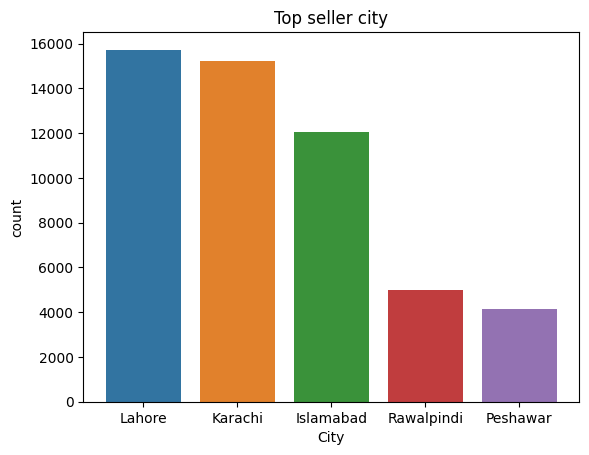

In [13]:
ax = sns.barplot(x=top5SalesCity, y=top5SalesCount, hue=top5SalesCity)
ax.set_title("Top seller city")
plt.plot()

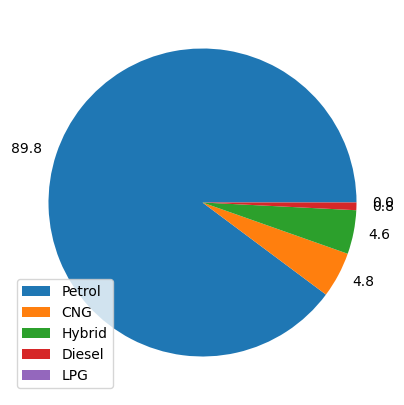

In [14]:
engineCount = [round((value/len(df))*100,1) for value in df['Engine_Type'].value_counts()]
plt.figure(figsize=(12,5))
ax = plt.pie(x=engineCount, labels=engineCount)
plt.legend(df['Engine_Type'].unique())
plt.show()

In [14]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['Transmission'] = encoder.fit_transform(df['Transmission'])
df['Engine_Type'] = encoder.fit_transform(df['Engine_Type'])

##### "Make, Name, City" columns have a lot of unique values. OrdinalEncoder and LabelEncoder are not appropriate in this situation

In [15]:
from category_encoders import TargetEncoder

encoder = TargetEncoder(cols=['Make', 'Name', 'City'])
df = encoder.fit_transform(df, df['Price'])


In [16]:
df['Make'] = df['Make'].round(2)
df['Name'] = df['Name'].round(2)
df['City'] = df['City'].round(2)

#### Year column

#### Years are replaced with ages of cars

In [17]:
from datetime import datetime
today = datetime.today().year

df['Year'] = df['Year'].map(lambda x: today - x)
df['Year']

0         7
1         3
2        10
3        11
4         8
         ..
76685     8
76686    14
76687     4
76688     5
76689    10
Name: Year, Length: 76690, dtype: int64

[]

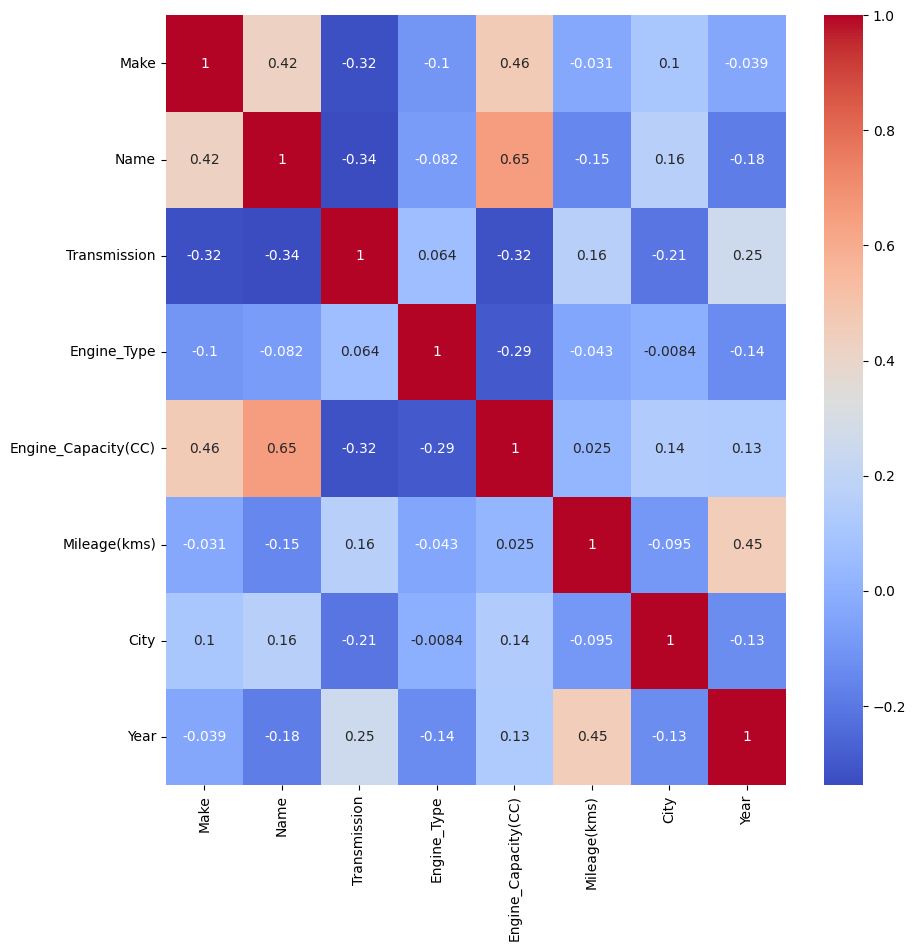

In [19]:
plt.figure(figsize=(10,10))
sns.heatmap(df.drop('Price', axis=1).corr(), annot=True,  cmap='coolwarm')
plt.plot()

[]

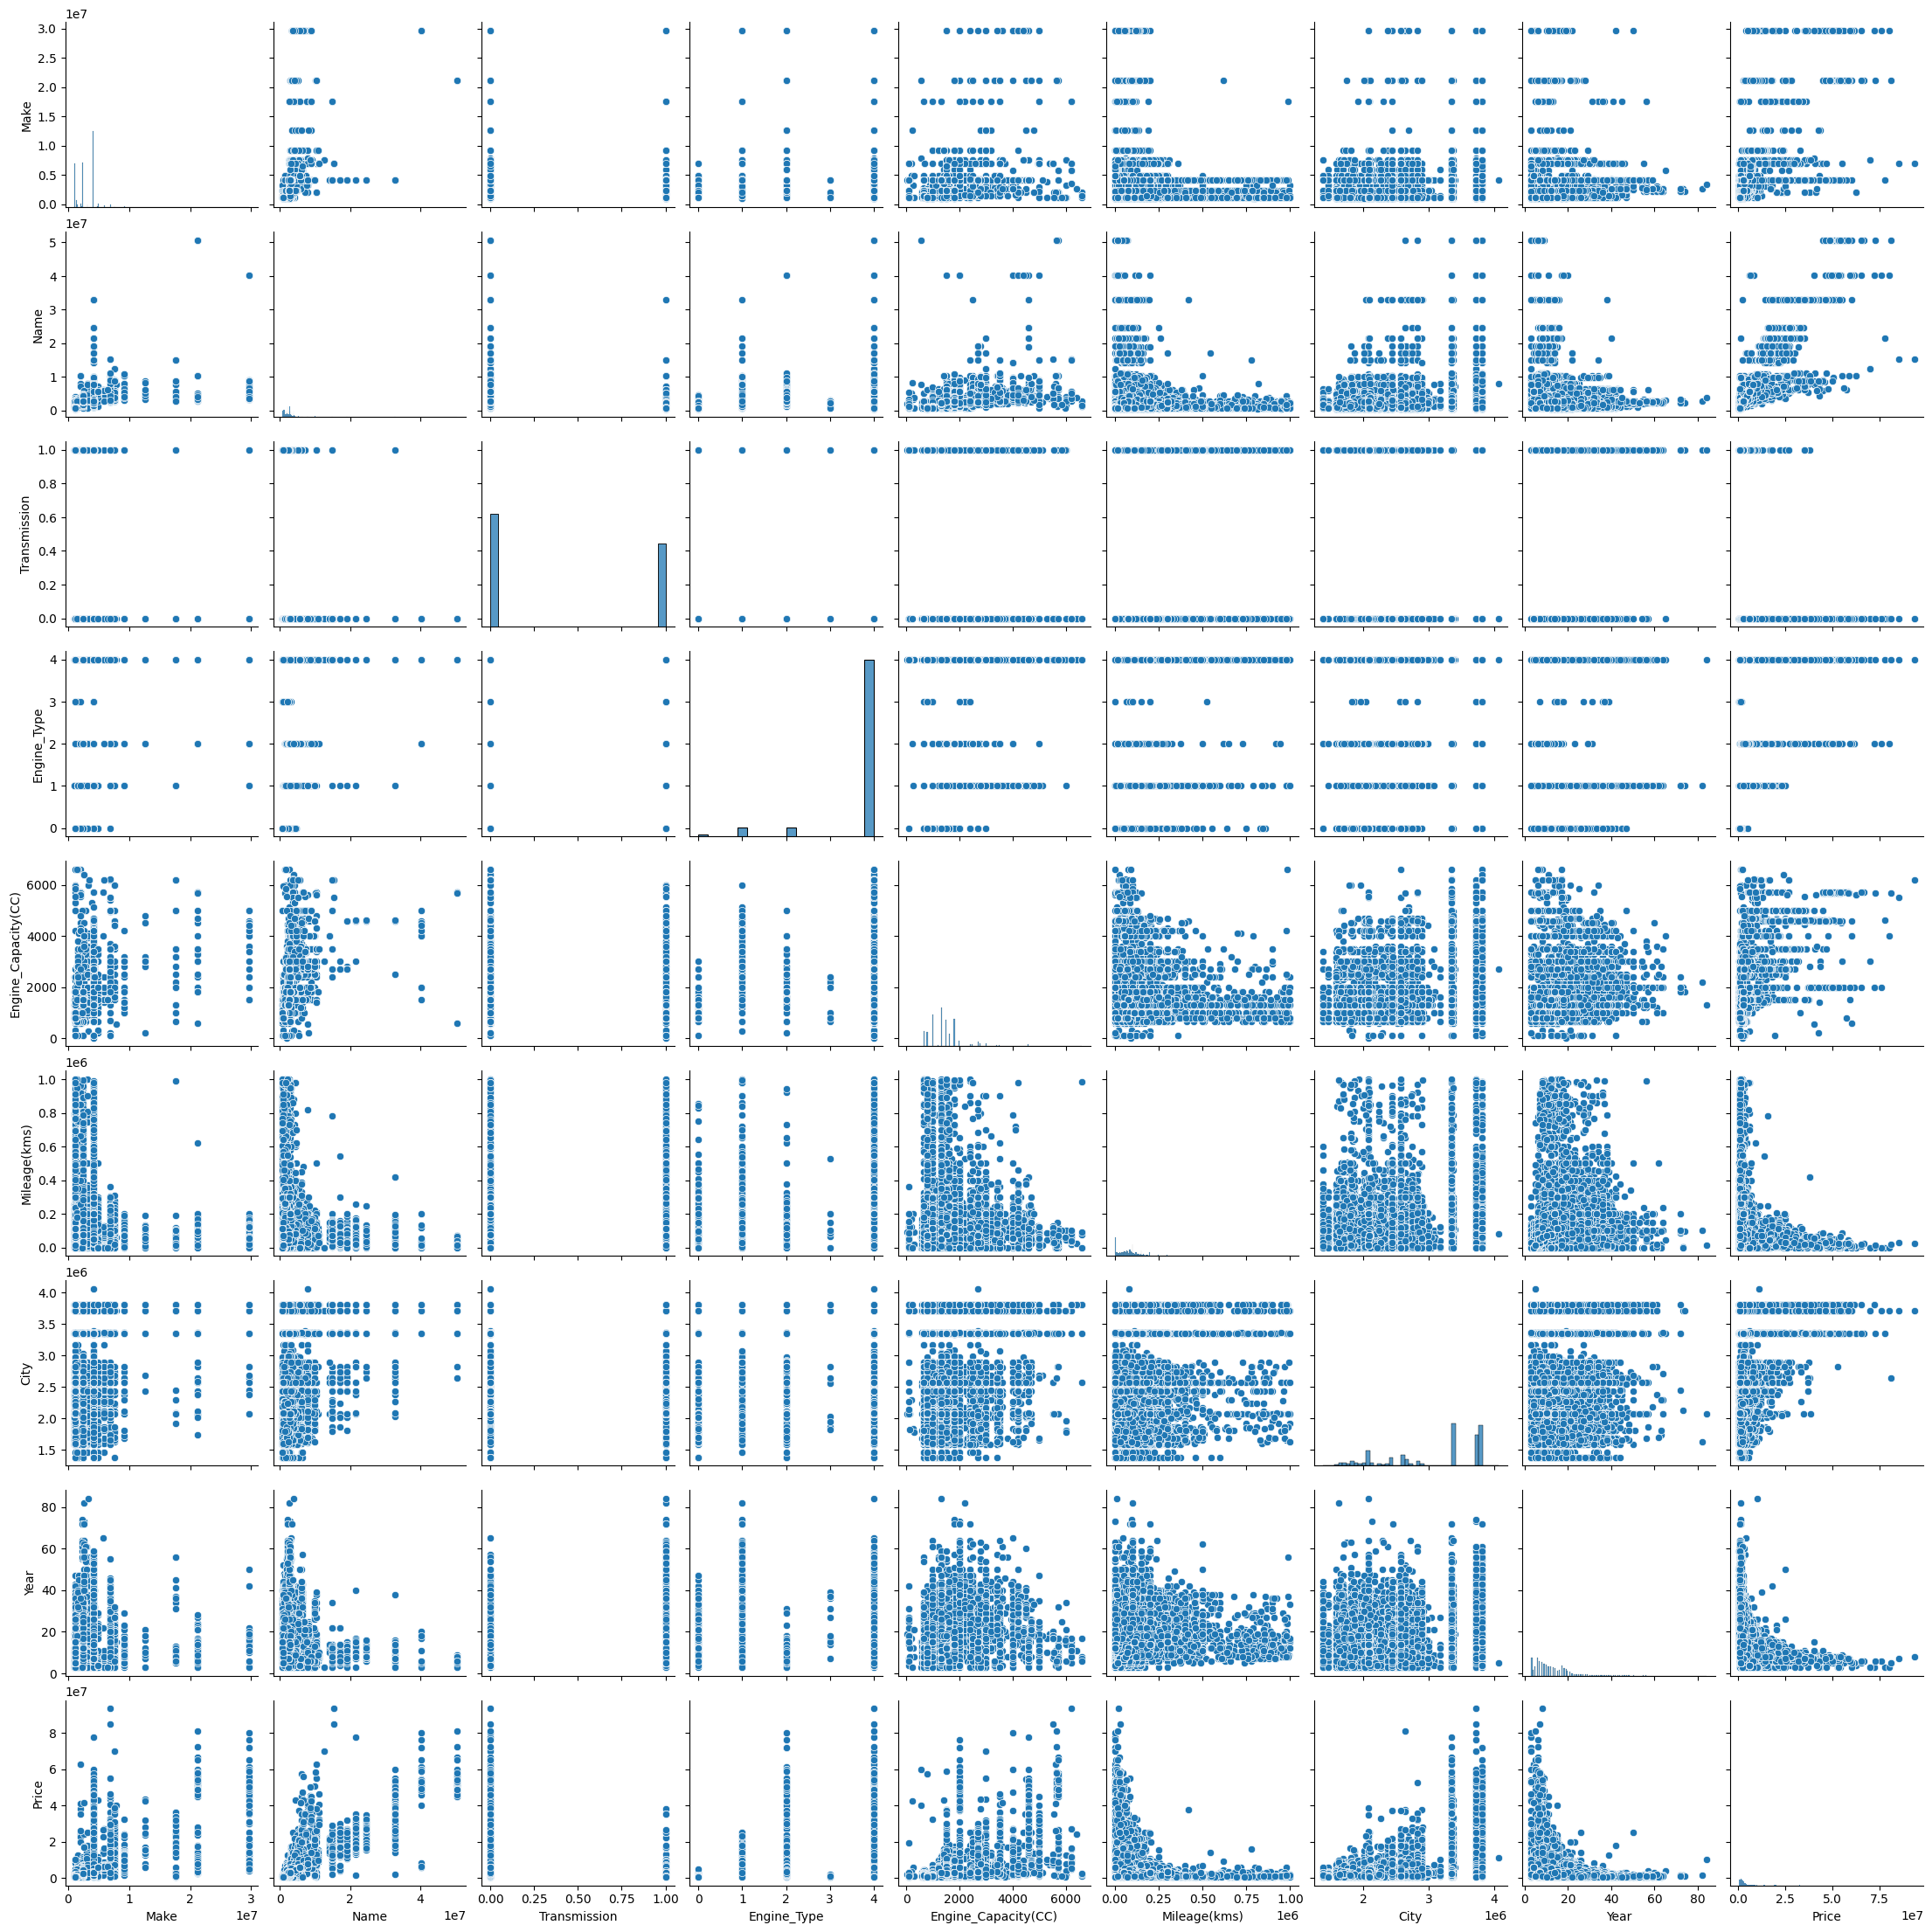

In [20]:
sns.pairplot(df)
plt.plot()

In [20]:
from sklearn.model_selection import train_test_split

x = df.iloc[:, :-1]
y = df.iloc[:, -1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=101)

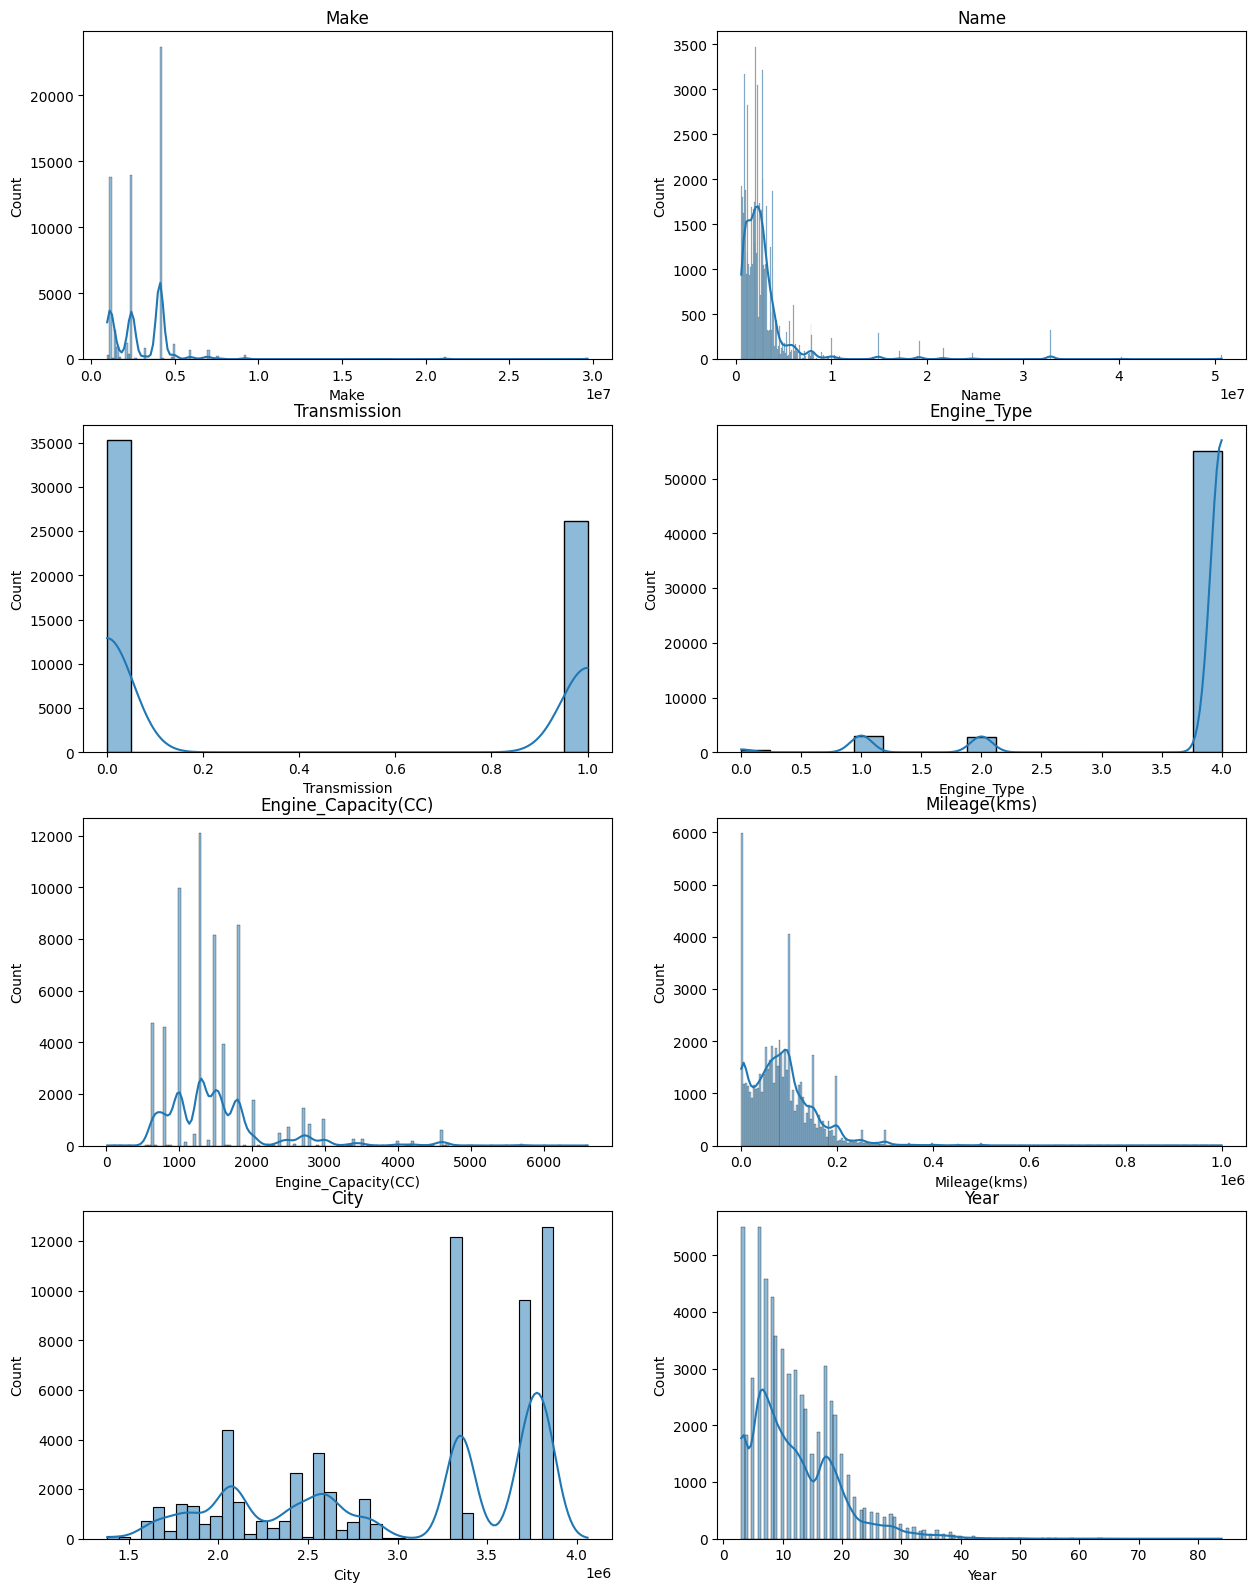

In [22]:
fig = plt.figure(figsize=(15,40))
for ind, col in enumerate(x_train.columns):
    ax = fig.add_subplot(len(x_train.columns), 2, ind+1)
    sns.histplot(x_train[col], kde=True)
    ax.set_title(col)
plt.show()

In [21]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

### Building a model

In [37]:
models = {
    'Linear Regression': LinearRegression(),
    'XGBoost': XGBRegressor(),
    'Random Forest': RandomForestRegressor()
}


for model_name, model in models.items():
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    print(f"{model_name} Mean Absolute Error: {mean_absolute_error(y_test, predictions)}")
    print(f"{model_name} Mean Squared Error: {mean_squared_error(y_test, predictions)}")
    print(f"{model_name} R2 score: {r2_score(y_test, predictions)}\n")

Linear Regression Mean Absolute Error: 761943.5347775423
Linear Regression Mean Squared Error: 3926517731771.4688
Linear Regression R2 score: 0.8030292025973218

XGBoost Mean Absolute Error: 263508.2384493374
XGBoost Mean Squared Error: 899089878616.289
XGBoost R2 score: 0.9548978350728521

Random Forest Mean Absolute Error: 225618.0780586525
Random Forest Mean Squared Error: 1038460270872.3619
Random Forest R2 score: 0.9479064245731935



In [25]:
model.__class__.__name__

'RandomForestRegressor'

In [26]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

#### RandomForest Regressor

In [28]:
hyper_params ={
    'n_estimators': [100, 200, 250, 300],
    'max_depth': [2, 20, 24, 30, 34 ],
}

rf_regressor = RandomForestRegressor(random_state=101)

In [29]:
grid_search_rf = GridSearchCV(estimator=rf_regressor,
                    param_grid=hyper_params,
                    scoring='r2',
                    cv=10,
                    n_jobs=-1,
                    return_train_score=True)

grid_search_rf.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=101),
             n_jobs=-1,
             param_grid={'max_depth': [2, 20, 24, 30, 34],
                         'n_estimators': [100, 200, 250, 300]},
             return_train_score=True, scoring='r2')

In [30]:
grid_search_rf.best_params_

{'max_depth': 24, 'n_estimators': 250}

In [31]:
grid_search_rf.best_score_

0.9670225050750341

In [35]:
rf_model = RandomForestRegressor(max_depth=24, n_estimators=250, random_state=101)
rf_model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [37]:
# The evaluation of the importance of the features on the analysis:
rf_model.feature_importances_

array([2.96485055e-02, 8.22768153e-01, 5.94734217e-04, 9.70468524e-03,
       4.24265093e-02, 2.01316923e-02, 4.28421581e-03, 7.04415043e-02])

In [39]:
rf_imp = pd.DataFrame({'importance':rf_model.feature_importances_}, index = df.drop('Price', axis=1).columns)
rf_imp.sort_values(by='importance', ascending=False)

,importance
Name,0.822768
Year,0.070442
Engine_Capacity(CC),0.042427
Make,0.029649
Mileage(kms),0.020132
Engine_Type,0.009705
City,0.004284
Transmission,0.000595


[]

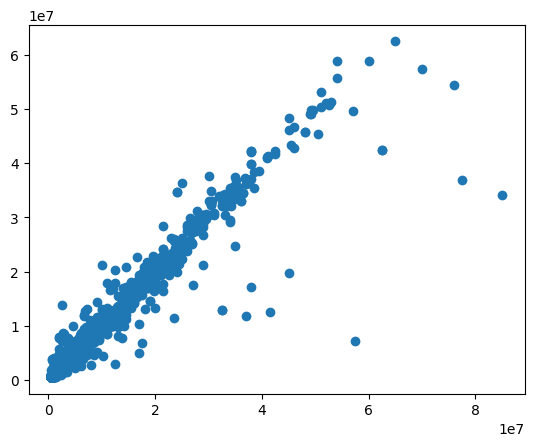

In [40]:
plt.scatter(y_test, y_pred)
plt.plot()

#### XGBoost Regressor

In [42]:
xgb_hyper_params = {
    'max_depth': [13, 17, 19, 23],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 0.9, 1]
}

xgb_model = XGBRegressor()

In [43]:
grid_search_xgb = GridSearchCV(estimator=xgb_model,
                    param_grid=xgb_hyper_params,
                    scoring='r2',
                    cv=10,
                    n_jobs=-1,
                    return_train_score=True)

grid_search_xgb.fit(x_train, y_train)

GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None,...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [13, 17, 19, 23],
                         'subsample': [0.5, 0.7, 0.9, 1]},
             return_train_score=True, scoring='r2')

In [44]:
grid_search_xgb.best_params_

{'learning_rate': 0.1, 'max_depth': 13, 'subsample': 0.7}

In [45]:
grid_search_xgb.best_score_

0.9684866334380804